# Navnet 2

Navnet version 2 approach combining self-supervised retrospective analysis, AE based anomaly detection, and patch navnet. The AE tries to predict what the right image sees based on a slightly larger patch from the left image and knowledge about where it was taken from.

In [1]:
import utils
train_path = "/home/michael/Desktop/BytesDB_train_normal/"
test_normal_path = "/home/michael/Desktop/BytesDB_test_normal/"
test_anormal_path = "/home/michael/Desktop/BytesDB_test_anormal/"

## Using Pandas for Dataloading and Management, New Data Management Class

In [2]:
train_data =  utils.BytesDataset(train_path, crop=90)
test_normal_data  =  utils.BytesDataset(test_normal_path, crop=90)
test_anormal_data  =  utils.BytesDataset(test_anormal_path, crop=90)

## Batch Handling

(90, 320, 3)


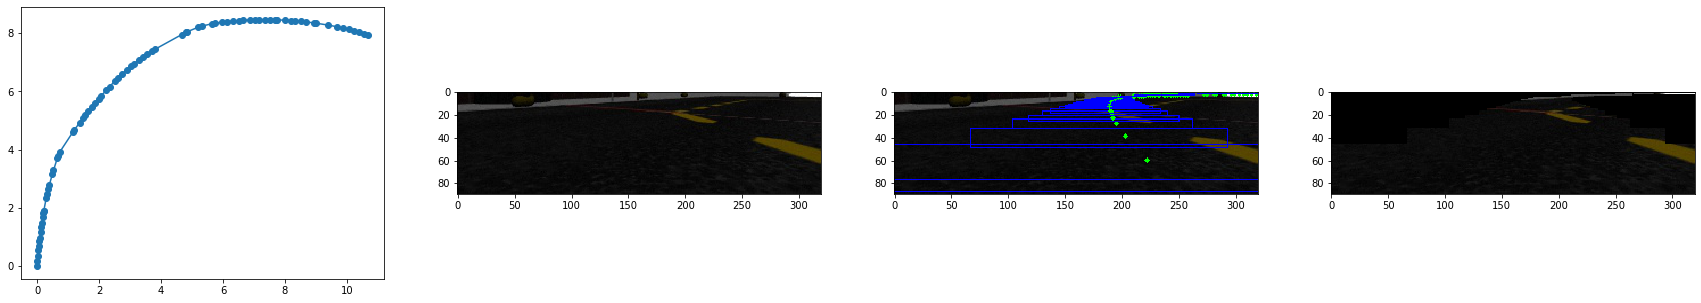

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

source = 50
target = 129
robot_width = 0.6
crop_line = 90

image = train_data.read_cv_image(source)
print(image.shape)
image_raw = image.copy()
path = train_data.path_source_to_target(source, target)

mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

for point in path:
    point_image =  utils.project_to_image(point, right=False)
    image = cv2.circle(image, (point_image[0], point_image[1]-crop_line), 2, (0,255,0), -1) 
    
    right_corner =  utils.project_to_image([point[0] - robot_width/2, point[1] - 0.1, point[2]], right=False)
    left_corner =  utils.project_to_image([point[0] + robot_width/2, point[1] + 0.1, point[2]], right=False)
    
    image = cv2.rectangle(image, (right_corner[0], right_corner[1]-crop_line), (left_corner[0], left_corner[1]-crop_line), (0,0,255), 1) 
    
    mask = cv2.rectangle(mask, (right_corner[0], right_corner[1]-crop_line), (left_corner[0], left_corner[1]-crop_line), (255, 255, 255), -1) 
    
res = cv2.bitwise_and(image_raw, image_raw, mask=mask)
    
fig = plt.figure(figsize=(30,5))
fig.add_subplot(1,4,1)
plt.scatter(path[:,0], path[:,1])
plt.plot(path[:,0], path[:,1])
fig.add_subplot(1,4,2)
plt.imshow(image_raw)
fig.add_subplot(1,4,3)
plt.imshow(image)
fig.add_subplot(1,4,4)
plt.imshow(res)

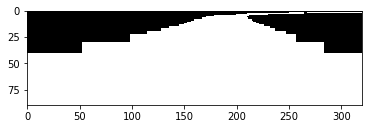

In [4]:
mask = utils.make_mask_from_path(path, vertical_crop=90, robot_width=0.6, step_height=0.3, image_shape=(90,320,3), right=False)
plt.imshow(mask)

In [5]:
mask_tensor = torch.from_numpy(mask).transpose(0,2).transpose(1,2)
print(mask_tensor.shape)

torch.Size([3, 90, 320])


In [12]:
import random

# returns right mask, right image, left mask, left image, path

def batch_generator(dataset, image_shape=(3,90,320), path_length=30, collision_buffering=35, vertical_crop=90, robot_width=0.6, max_dt=0.45, batch_size=16):
    while True:
        
        # create memory for training data
        
        left_images = torch.zeros((batch_size, image_shape[0], image_shape[1], image_shape[2]))
        right_images = torch.zeros((batch_size, image_shape[0], image_shape[1], image_shape[2]))
        
        left_masks = torch.zeros((batch_size, image_shape[0], image_shape[1], image_shape[2]))
        right_masks = torch.zeros((batch_size, image_shape[0], image_shape[1], image_shape[2])) 
        
        i = 0
        while i < batch_size:
            
            rand_source = random.randint(0, len(dataset.data)-1)
            if dataset.index_exists(rand_source) and dataset.index_exists(rand_source+1):
                target = min(rand_source + path_length, dataset.get_next_break(rand_source)-collision_buffering-1)
                if target - rand_source > 0:
                    try:
                        
                        # make sure no breaks in the data
                        for t in range(rand_source, target):
                            if dataset.data['dt'][t] > max_dt:
                                raise Exception("too large of a skip in data recording")
                                
                        path = dataset.path_source_to_target(rand_source, target)
                        
                        mask_left = torch.from_numpy(utils.make_mask_from_path(path, robot_width=robot_width, vertical_crop=vertical_crop, image_shape=(image_shape[1], image_shape[2], image_shape[0]))).transpose(0,2).transpose(1,2)
                        mask_right = torch.from_numpy(utils.make_mask_from_path(path, robot_width=robot_width, vertical_crop=vertical_crop, image_shape=(image_shape[1], image_shape[2], image_shape[0]), right=True)).transpose(0,2).transpose(1,2)
                                                
                        left_images[i] = dataset.read_torch_image(rand_source)
                        left_masks[i] = mask_left

                        right_images[i] =  dataset.read_torch_image(rand_source, right=True)
                        right_masks[i] = mask_right

                        i += 1
                    except Exception as e:
                        pass
                        
        yield right_masks, right_images, left_masks, left_images
        

In [13]:
batch = next(batch_generator(train_data))

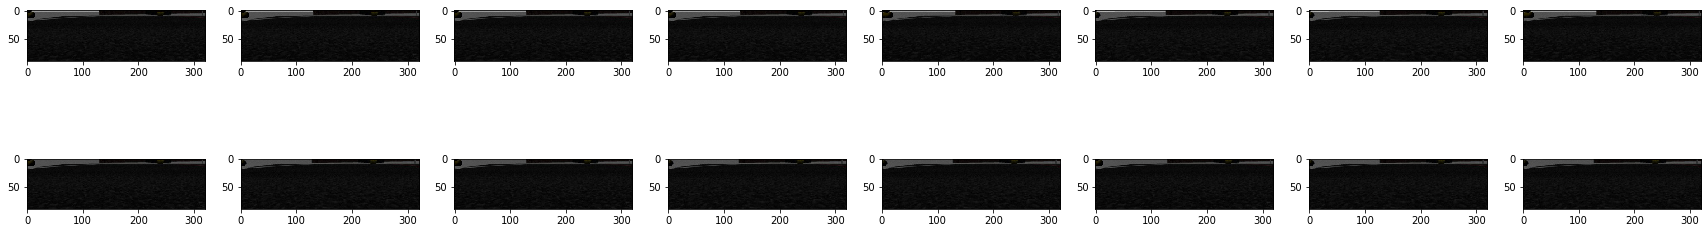

In [14]:
fig = plt.figure(figsize=(30,5))
for i in range(16):
    fig.add_subplot(2,8,i+1)
    plt.imshow(utils.torch_image_to_cv_image(batch[1][i]))

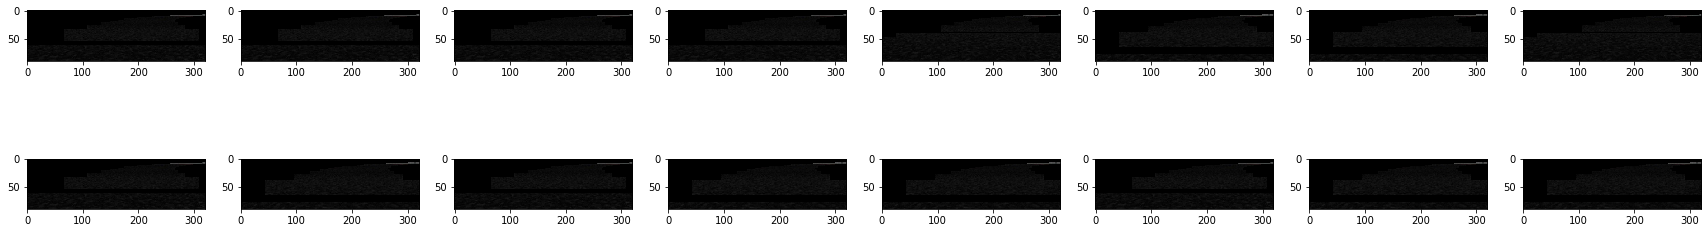

In [15]:
fig = plt.figure(figsize=(30,5))
for i in range(16):
    fig.add_subplot(2,8,i+1)
    plt.imshow(utils.torch_image_to_cv_image(batch[1][i]*batch[2][i])*batch[2][i].transpose(0,2).transpose(0,1).numpy())

## Create the autoencoder model

In [16]:
import torch.nn as nn
import torchvision


def same_padding(stride, width, height, filter_size):
    pad_w = ((stride-1)*width-stride+filter_size)/2
    pad_h = ((stride-1)*height-stride+filter_size)/2
    return (int(pad_h),int(pad_w))

class NavNet(nn.Module):
    def __init__(self, input_shape=(3, 90, 320)):
        super(NavNet, self).__init__()
        
        mobilenet = torchvision.models.mobilenet_v2(pretrained=True)
        # Turn off mobilenet training
        for param in mobilenet.parameters():
            param.requires_grad = False
        # we only want the feature extractor
        self.encoder = mobilenet.features
        
        self.decoder = torch.nn.Sequential(
            nn.UpsamplingNearest2d((input_shape[1]//8, input_shape[2]//8)),
            nn.Conv2d(1280, 512, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2],input_shape[1],5)),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            
            nn.UpsamplingNearest2d((input_shape[1]//4, input_shape[2]//4)),
            nn.Conv2d(512, 128, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2],input_shape[1],5)),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            
            nn.UpsamplingNearest2d((input_shape[1]//2, input_shape[2]//2)),
            nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2],input_shape[1],5)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            
            nn.UpsamplingNearest2d((input_shape[1], input_shape[2])),
            nn.Conv2d(64, 32, kernel_size=5, stride=1, padding=same_padding(1,input_shape[2],input_shape[1],5)),
            nn.ReLU(),
            
            nn.Conv2d(32, 3, kernel_size=1, stride=1, padding=same_padding(1,input_shape[2],input_shape[1],1))
        )
    
    def forward(self, img):
        embedding = self.encoder(img)
        output = self.decoder(embedding)
        return output
        

In [17]:
navnet = NavNet()
pytorch_total_params = sum(p.numel() for p in navnet.parameters())
print("Model Size: ", pytorch_total_params)
output = navnet.forward(batch[0])
print(output.shape)

Model Size:  20504515
torch.Size([16, 3, 90, 320])


## Train the model

In [11]:
import torchvision

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

PyTorch Version:  1.5.0
Torchvision Version:  0.6.0
cuda:0


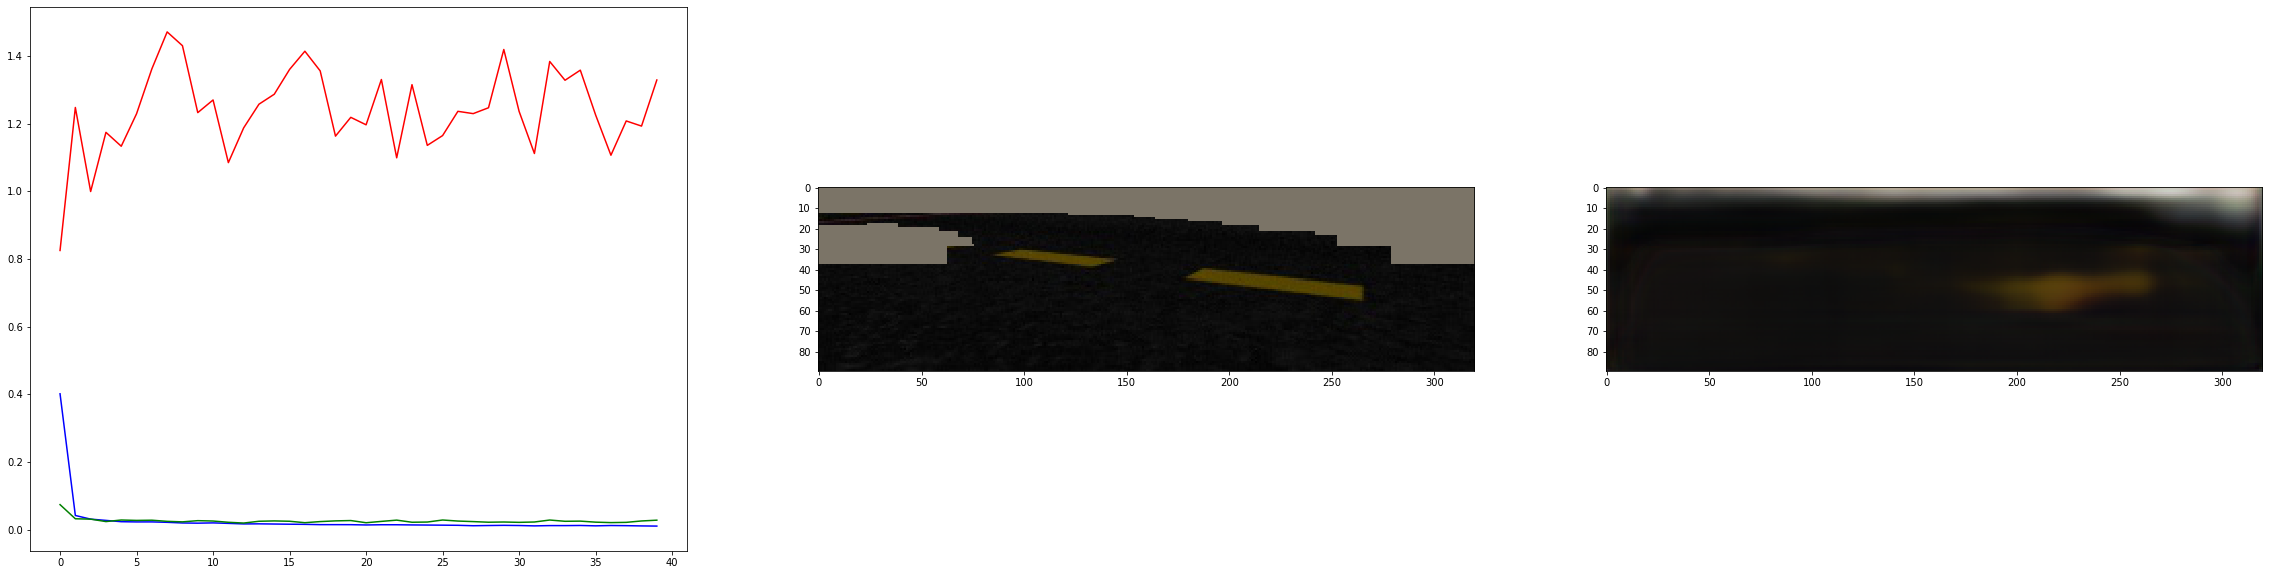

[0.4018494353443384, 0.04228041872382164, 0.031502413898706436, 0.027756834365427495, 0.023902546186000108, 0.023234277479350567, 0.02331450179219246, 0.022065523099154234, 0.020133296493440866, 0.01958033874630928, 0.02036884730681777, 0.018943825103342533, 0.017316853664815425, 0.01754705833271146, 0.01701008204370737, 0.016481618266552686, 0.016074919160455465, 0.015178451472893357, 0.015188691634684802, 0.0150978478603065, 0.014238611403852701, 0.014906704481691123, 0.014868468325585128, 0.014334577880799771, 0.013986723609268665, 0.013645804189145565, 0.013252410050481557, 0.011989385960623622, 0.012596387360244989, 0.013117165993899107, 0.012607923476025462, 0.011550576174631715, 0.01237796364352107, 0.01234664499759674, 0.012738859988749027, 0.011669572433456779, 0.012608786020427943, 0.012190133482217789, 0.011429542787373065, 0.010923948548734188]
#########
[0.07432406581938267, 0.03256056625396013, 0.031449257768690585, 0.024251959659159182, 0.028897611051797868, 0.0277125671

In [12]:
from IPython.display import clear_output

num_epochs = 40
train_steps_per_epoch = 50
test_steps_per_epoch = 10
batch_size = 8

collision_buffer = 35
path_length = 30

# Make Model
navnet = NavNet().to(device)

optimizer = torch.optim.Adam(navnet.parameters(), lr=1e-4)
criterion = nn.MSELoss()

train_batch_gen = batch_generator(train_data, image_shape=(3,90,320), path_length=path_length, collision_buffering=collision_buffer, batch_size=batch_size)
test_normal_batch_gen = batch_generator(test_normal_data, image_shape=(3,90,320), path_length=path_length, collision_buffering=collision_buffer, batch_size=batch_size)
test_anormal_batch_gen = batch_generator(test_anormal_data, image_shape=(3,90,320), path_length=path_length, collision_buffering=collision_buffer, batch_size=batch_size)

train_loss = []
normal_test_loss = []
anormal_test_loss = []

for epoch in range(num_epochs):
        
    # Train
    avg_train_loss = 0
    for step in range(train_steps_per_epoch):
        optimizer.zero_grad()
        right_masks, right_images, left_masks, left_images = next(train_batch_gen)
        left_input = left_images * left_masks
        output = navnet(left_input.to(device))
        loss = criterion(output*left_masks.to(device), left_input.to(device))
        loss.backward()
        optimizer.step()
        avg_train_loss += loss.item()
        
    avg_train_loss /= train_steps_per_epoch
    train_loss.append(avg_train_loss)
    
    # Normal / Anormal testing
    
    # Normal
    avg_normal_test_loss = 0
    disp_output = None
    disp_input = None
    for step in range(test_steps_per_epoch):
        right_masks, right_images, left_masks, left_images = next(test_normal_batch_gen)
        left_input = left_images * left_masks
        output = navnet(left_input.to(device))
        loss = criterion(output*left_masks.to(device), left_input.to(device))
        avg_normal_test_loss += loss.item()
        
        # additional visualization ability
        disp_output = output
        disp_input = left_input
        
    avg_normal_test_loss /= test_steps_per_epoch
    normal_test_loss.append(avg_normal_test_loss)
    
    # Anormal
    avg_anormal_test_loss = 0
    for step in range(test_steps_per_epoch):
        right_masks, right_images, left_masks, left_images = next(test_anormal_batch_gen)
        left_input = left_images * left_masks
        output = navnet(left_input.to(device))
        loss = criterion(output*left_masks.to(device), left_input.to(device))
        avg_anormal_test_loss += loss.item()
        
    avg_anormal_test_loss /= test_steps_per_epoch
    anormal_test_loss.append(avg_anormal_test_loss)
    
    
    
    # Plot the losses in realtime
    clear_output(wait=True)
    
    fig = plt.figure(figsize=(40,10))
    fig.add_subplot(1,3,1)
    
    plt.plot(train_loss,  color='blue', label='train loss')
    plt.plot(normal_test_loss,  color='green', label='normal test loss')
    plt.plot(anormal_test_loss,  color='red', label='anormal test loss')

    fig.add_subplot(1,3,2)
    plt.imshow(utils.torch_image_to_cv_image(disp_input[0]))
    
    fig.add_subplot(1,3,3)
    plt.imshow(utils.torch_image_to_cv_image(disp_output[0].cpu().detach()))
    
    plt.show()
    
print(train_loss)
print("#########")
print(normal_test_loss)
print("#########")
print(anormal_test_loss)

## Visualize the model

In [26]:
import time, cv2
import numpy as np

patch_side_len = 32
threshold = 0.5
crop_line = 90

navnet.eval()
for i in range(1, len(test_normal_data.data)):
    img = test_normal_data.read_torch_image(i)
    if len(img) > 0:
        cv_image = utils.torch_image_to_cv_image(img)

        image = img.unsqueeze(0).to(device)
        model_output = navnet(image)

        heat_map = ((image-model_output)**2).squeeze(0).cpu().detach().transpose(0,2).transpose(0,1).numpy()

        mask = np.sum(heat_map, axis=2)
        mask = (mask > threshold).astype(int)

        if loss > threshold:
            score = 1
        else:
            score = 0
            
        red = np.ones((cv_image.shape[0], cv_image.shape[1])) * mask
        green = np.ones((cv_image.shape[0], cv_image.shape[1])) * (1 - mask)
        color_mask = np.zeros(cv_image.shape)
        color_mask[:,:,0] = red
        color_mask[:,:,1] = green
        color_mask = (color_mask*255).astype('uint8')
        
        color_mask = cv2.medianBlur(color_mask,17)
        
        disp_image = cv2.addWeighted((cv_image*255).astype('uint8'),0.7,color_mask,0.3,0)  
        
        cv2.imshow('image', cv2.cvtColor(disp_image, cv2.COLOR_BGR2RGB))
        cv2.waitKey(50)

## Save the model

In [27]:
# Standard pytorch model saving/loading
name = "navnet-ae-full-predictor-v2-6-14-20"
torch.save(navnet.state_dict(), name + ".pt")
navnet.load_state_dict(torch.load(name + ".pt")) # test reloading model

<All keys matched successfully>

In [18]:
name = "navnet-ae-full-predictor-v2-6-14-20"
navnet.load_state_dict(torch.load(name + ".pt"))

NameError: name 'name' is not defined